#In this task i have used 3 different models to predict car prices. Performed EDA and data cleaning before training.

#Imported Regression Models and other libraries

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from IPython.core.display import deepcopy
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
%load_ext google.colab.data_table

In [2]:
df_cars = pd.read_csv('/content/car_data.csv')

**Shape of Data**

In [3]:
df_cars.shape

(80572, 10)

In [4]:
df_cars.head()

,Make,Model,Version,Price,Make_Year,CC,Assembly,Mileage,Registered City,Transmission
0,Honda,Insight,NaN,7400000.0,2019,1500,Imported,2000,Un-Registered,Automatic
1,Mitsubishi,Minica,Black Minica,1065000.0,2019,660,Imported,68000,Lahore,Automatic
2,Audi,A6,1.8 TFSI Business Class Edition,9300000.0,2015,1800,Local,70000,Lahore,Automatic
3,Toyota,Aqua,G,2375000.0,2014,1500,Imported,99900,Islamabad,Automatic
4,Honda,City,1.3 i-VTEC,2600000.0,2017,1300,Local,55000,Islamabad,Manual


**Showing datatypes of each coloumn**

In [5]:
df_cars.dtypes

Make               object
Model              object
Version            object
Price              object
Make_Year           int64
CC                  int64
Assembly           object
Mileage             int64
Registered City    object
Transmission       object
dtype: object

#Changing price type from object to Float

In [6]:
df_cars['Price'] = pd.to_numeric(df_cars['Price'], errors='coerce', downcast='integer')


**Checking for Null values in Data**

In [7]:
df_cars.isnull().sum()

Make                  0
Model                 0
Version            6772
Price              1209
Make_Year             0
CC                    0
Assembly              0
Mileage               0
Registered City       0
Transmission          0
dtype: int64

**Substituting for all null Version values with the mean of group having same 'Make', 'Model', 'Assembly' and 'Transmission'**

In [8]:
# Calculate the mode of 'Version' within each 'Make', 'Model', 'Assembly', and 'Transmission' group
mode_Version_by_make_model = df_cars[df_cars['Version'].notna()].groupby(['Make', 'Model', 'Assembly', 'Transmission'])['Version'].agg(lambda x: x.mode().iat[0])

# Replace NaN values in the 'Version' column with the mode value of the respective group
df_cars.loc[df_cars['Version'].isna(), 'Version'] = df_cars[df_cars['Version'].isna()].apply(
    lambda row: mode_Version_by_make_model.get((row['Make'], row['Model'], row['Assembly'], row['Transmission'])),
    axis=1
)

**After Version null value is filled with mean. There are still some rows which donot belong to any group.**

In [9]:
(df_cars[df_cars['Version'].isna()]).shape

(726, 10)

Dropping those values who dont belong to make,model,assembly,transmission group.

In [10]:
new_df = df_cars.dropna(subset=['Version'])
new_df.shape

(79846, 10)

#Substituting for all null Price values with the mean of group having same 'Make', 'Model', 'Assembly' and 'Transmission'

In [11]:
mean_price_by_model = new_df.groupby(['Make', 'Model', 'Version', 'Assembly', 'Transmission'])['Price'].mean()
new_df['Price'] = new_df.groupby(['Make', 'Model', 'Version', 'Assembly', 'Transmission'])['Price'].transform(lambda x: x.fillna(mean_price_by_model.get(tuple(x.name))))

<ipython-input-11-0254f54f3b1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Price'] = new_df.groupby(['Make', 'Model', 'Version', 'Assembly', 'Transmission'])['Price'].transform(lambda x: x.fillna(mean_price_by_model.get(tuple(x.name))))


**Dropping values which do not belong to group. Also converting type of price from float to int**

In [12]:
new_df = new_df.dropna(subset=['Price'])
new_df['Price'] = new_df['Price'].astype(int)

<ipython-input-12-2b31d5c9f986>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Price'] = new_df['Price'].astype(int)


**No Null Values after applying some preprocessing on given data.**

In [13]:
new_df.isnull().sum()

Make               0
Model              0
Version            0
Price              0
Make_Year          0
CC                 0
Assembly           0
Mileage            0
Registered City    0
Transmission       0
dtype: int64

**There was some wrong values in CC column. Some cars have CC less tahn 660 and more than 6600. So i just substituted CC value for those cars who have less than 660 and more than 6600.**

In [14]:
mean_cc_by_make_model = new_df[(new_df['CC'] >= 660) & (new_df['CC'] <= 6600)].groupby(['Make', 'Model','Version','Transmission'])['CC'].mean()

# Replace 'CC' values < 660 with the mean of the respective 'make','Model' and 'version' group
new_df.loc[new_df['CC'] < 660, 'CC'] = new_df[new_df['CC'] < 660].apply(lambda row: mean_cc_by_make_model.get((row['Make'], row['Model'],row['Version'],row['Transmission'])), axis=1)
new_df.loc[new_df['CC'] > 6000, 'CC'] = new_df[new_df['CC'] > 6000].apply(lambda row: mean_cc_by_make_model.get((row['Make'], row['Model'],row['Version'],row['Transmission'])), axis=1)


**There is still One car which do not belong to a group, so i just substituted Automatic transmission CC value in manual car given below.**

In [15]:
new_df[new_df['CC'].isna()]

,Make,Model,Version,Price,Make_Year,CC,Assembly,Mileage,Registered City,Transmission
68917,Mitsubishi,Town,Box,640000,2014,NaN,Imported,89858,Lahore,Manual


In [16]:
new_df.loc[68917,'CC'] = 660
new_df['CC'] = new_df['CC'].astype(int)

#Used LabelEncoder to convert String data in Int data so that linear regression and polynomial regression model can work on it.

In [17]:
label_dataset = LabelEncoder()

columns_to_encode = ['Transmission', 'Registered City', 'Assembly', 'Make', 'Model', 'Version']

new_df[columns_to_encode] = new_df[columns_to_encode].apply(lambda x: label_dataset.fit_transform(x))

**All columns are converted to integer value**

In [18]:
new_df

,Make,Model,Version,Price,Make_Year,CC,Assembly,Mileage,Registered City,Transmission
0,17,124,692,7400000,2019,1500,0,2000,177,0
1,34,158,304,1065000,2019,660,0,68000,96,0
2,0,12,75,9300000,2015,1800,1,70000,96,0
3,47,23,600,2375000,2014,1500,0,99900,65,0
4,17,64,36,2600000,2017,1300,1,55000,65,1
...,...,...,...,...,...,...,...,...,...,...
80567,45,40,1137,750000,2015,800,1,98000,96,1
80568,45,22,1144,1480000,2020,660,1,7800,79,1
80569,47,70,672,2700000,2016,1300,1,81000,65,0
80570,12,264,1038,600000,2013,1000,1,2,96,1


#Plotting Price again Mileage so that we can view how our price is behaving with Mileage run.

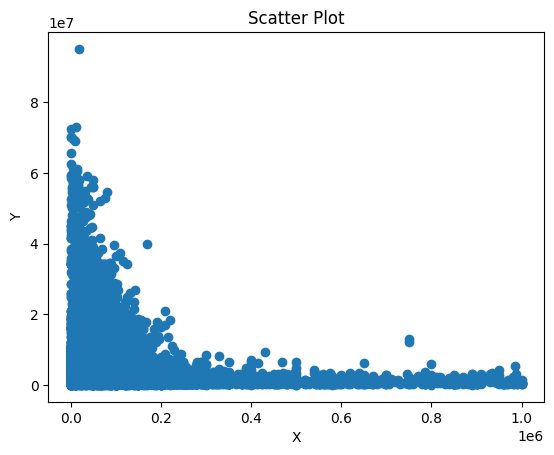

In [19]:
x = new_df['Mileage']
y = new_df['Price']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')

plt.show()

#Printing all columns correlation with Price. So that if any column has minimum effect we can just ignore it.

#Make and Model do not have soo much impact on RandomForest as model R2 score with column is 0.94 and without make and model is 0.91

In [20]:
columns = new_df.columns
for column in columns:
  if(column!='Price'):
    x = new_df[column]
    y = new_df['Price']

    # Calculate the correlation coefficient
    correlation = np.corrcoef(x, y)[0, 1]

    
    print(f"Correlation between {column} and Price is: ", correlation)

Correlation between Make and Price is:  0.010880920207382612
Correlation between Model and Price is:  0.09528481565635759
Correlation between Version and Price is:  -0.15650510356692537
Correlation between Make_Year and Price is:  0.24333382573978352
Correlation between CC and Price is:  0.6634186770376872
Correlation between Assembly and Price is:  -0.24566875736332122
Correlation between Mileage and Price is:  -0.16132875766624982
Correlation between Registered City and Price is:  0.1981351323061547
Correlation between Transmission and Price is:  -0.3555037478748161


In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79827 entries, 0 to 80571
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Make             79827 non-null  int64
 1   Model            79827 non-null  int64
 2   Version          79827 non-null  int64
 3   Price            79827 non-null  int64
 4   Make_Year        79827 non-null  int64
 5   CC               79827 non-null  int64
 6   Assembly         79827 non-null  int64
 7   Mileage          79827 non-null  int64
 8   Registered City  79827 non-null  int64
 9   Transmission     79827 non-null  int64
dtypes: int64(10)
memory usage: 8.7 MB


**Creating X and y data so that model can be trained**

In [22]:
X = new_df.drop(['Price'],axis=1)
y = new_df['Price']

**Splitting the data 80% for training**

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

#Standard Scaler to scale data

In [24]:
sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

#Linear Regression Model with an R2 score of 0.54.

In [25]:
#Standard Scaler to scale data
regr = LinearRegression()
regr.fit(X_train, y_train)
pred_test = (regr.predict(X_test))
print("R2 Score: %.2f" % r2_score(y_test, pred_test))

R2 Score: 0.54


#Linear Regression with Polynomial features gives R2_score of 0.90

In [26]:
# Set the desired degree
poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on the training and testing sets
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)



print("R2 Score: %.2f" % r2_score(y_test, y_test_pred))


R2 Score: 0.90


#RandomForestRegressor Model with R2_score as 0.94

In [27]:
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)


print("R2 Score: %.2f" % r2_score(y_test, y_pred))

R2 Score: 0.94


#RandomForest is more accurate also less overfitted model beacause in polynomial we are using polynomial till 5th power which makes it a bit overfitted.